# Assignement - Gender classification on audio files

This notebook contains the codes and explanations for a gender classifier for audio files. Based on [LibriSpeech ASR speech corpus](http://www.openslr.org/12/), features are extracted from the audio files and 4 different Machine learning models are trained in order to build a gender classifier (Man/Woman's voice).

The corpus used in this assignement is the "dev-clean".

## Prerequisites

### Data

The dev-clean [LibriSpeech ASR corpus](http://www.openslr.org/12/).

### Libraries 

* python speech features:  a library used to extract MFCCs features of the audio files. see [github repo](https://github.com/jameslyons/python_speech_features)
```
pip install python_speech_features 
```


* pandas
```
pip install pandas
```

* soundfile
```
pip install soundfile
```

* scikit learn, v > 0.18 required to use MLP neural network

```
pip install scikit-learn==0.18.rc2
```

* TensorFlow is used for the deep learning model

```
pip install tensorflow
```

* Keras is used on top of TensorFlow

```
pip install keras
```



## Data info

Let's first take a look at our data (Number of files, number of speakers, etc...)

In [1]:
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
corpus_path = "LibriSpeech/dev-clean/"

# Get the list of speakers ids
speaker_ids = os.listdir(corpus_path)
print("There are {} speakers overall".format(len(speaker_ids)))

# Get the list of chapters for each users
speakerChapters = {}
for speaker in speaker_ids:
    speakerChapters[speaker] = os.listdir("".join([corpus_path, speaker, "/"]))
    
# Get the number of chapters overall
print("There are {} chapters overall".format(sum(map(lambda x: len(speakerChapters[x]), speakerChapters.keys()))))

# Get all unique chapters in the corpus
unique_chapters = set ()
for speaker in speaker_ids:
    unique_chapters = unique_chapters | set(speakerChapters[speaker])
    
print("There are {} unique chapters overall".format(len(unique_chapters)))

# Get the list of files for each users
speakerFiles = {}
allfiles = []
for speaker in speaker_ids:
    for chapter in speakerChapters[speaker]:
        path = "".join([corpus_path, speaker, "/", chapter, "/"])
        files = os.listdir(path)
        speakerFiles[speaker] = list(map(lambda x: path + x, files))
        allfiles += files

# Get files extensions and count occurences
file_ext_occurences = Counter(list(map(lambda x: x.split(".")[-1], allfiles)))
for extension, nb in file_ext_occurences.items():
    print("There are {} {} files".format(nb, extension))

There are 40 speakers overall
There are 97 chapters overall
There are 97 unique chapters overall
There are 97 txt files
There are 2703 flac files


** We notice two intersting things: **
* Each chapter is unique (read by one user only)
* All audio files have "flac" format. 

## Getting gender info on users

Obtain users info from the SPEAKERS.TXT file

In [3]:
users_path = "LibriSpeech/SPEAKERS.TXT"
speakerGender = {}
for line in open(users_path):
    li=line.strip()
    if not li.startswith(";"):
        params = list(map(lambda x: x.strip(), line.split("|")))
        user_id = params[0]
        if user_id in speaker_ids:
            speakerGender[user_id] = params[1]
gender_counter = Counter(map(lambda x: x[1], speakerGender.items()))
print("There are {} female speakers and {} male speakers".format(gender_counter['F'], gender_counter['M']))

There are 20 female speakers and 20 male speakers


## Features extractions

We extract the MFCC features from all audio files using the python_speech_features library.

In [4]:
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
import soundfile as sf

# Use the speech features extraction library to get the 13 MFCC features of an audio file
def computeMFCC(audio):
    with open(audio, 'rb') as f:
        sig, rate = sf.read(f)
    mfcc_feat = mfcc(sig,rate)
    return mfcc_feat

**Create a dataframe with for each audio file:**
* The speaker's id
* Its MFCC features
* The gender of the speaker

In [6]:
# Link all audio files with its speaker
all_speaker_audio = []
for speaker in speaker_ids:
    all_speaker_audio += list(map(lambda x: (speaker, x), filter(lambda x: x.split(".")[-1] == "flac", speakerFiles[speaker])))

# Create a dataFrame containing the speakers id, the computed MFCC and the gender of the speaker
'''
UNCOMMENT TO RUN IF YOU DON'T HAVE ALREADY data.json

data = pd.DataFrame(list(map(lambda x: [x[0], computeMFCC(x[1]), speakerGender[x[0]]], all_speaker_audio)))
data.columns = ["speaker", "MFCC", "gender"]
data.to_json("data.json")
'''
# Load the precomputed data
data = pd.read_json("data.json")
# Reform numpy array from json file
data.MFCC = data.MFCC.map(lambda x: np.array(x))

data.sample(5)

,MFCC,gender,speaker
535,"[[-8.0348522519, -18.8851876868, -3.5041412171...",F,3081
272,"[[-9.6011284134, -12.8485972265, -27.845265996...",M,2428
214,"[[-12.1971316432, -7.2681579985, -5.6809013998...",M,174
822,"[[-9.1045745944, -15.9415374045, -13.916896736...",F,5895
413,"[[-13.254809371, 2.849059447, -7.8966948691, -...",M,6295


## Features analysis

Let's take a look at what the MFCC features look like. We compare an audio file from a female and a male speaker.

This may help to understand what is relevant in those features to classify a woman and a man

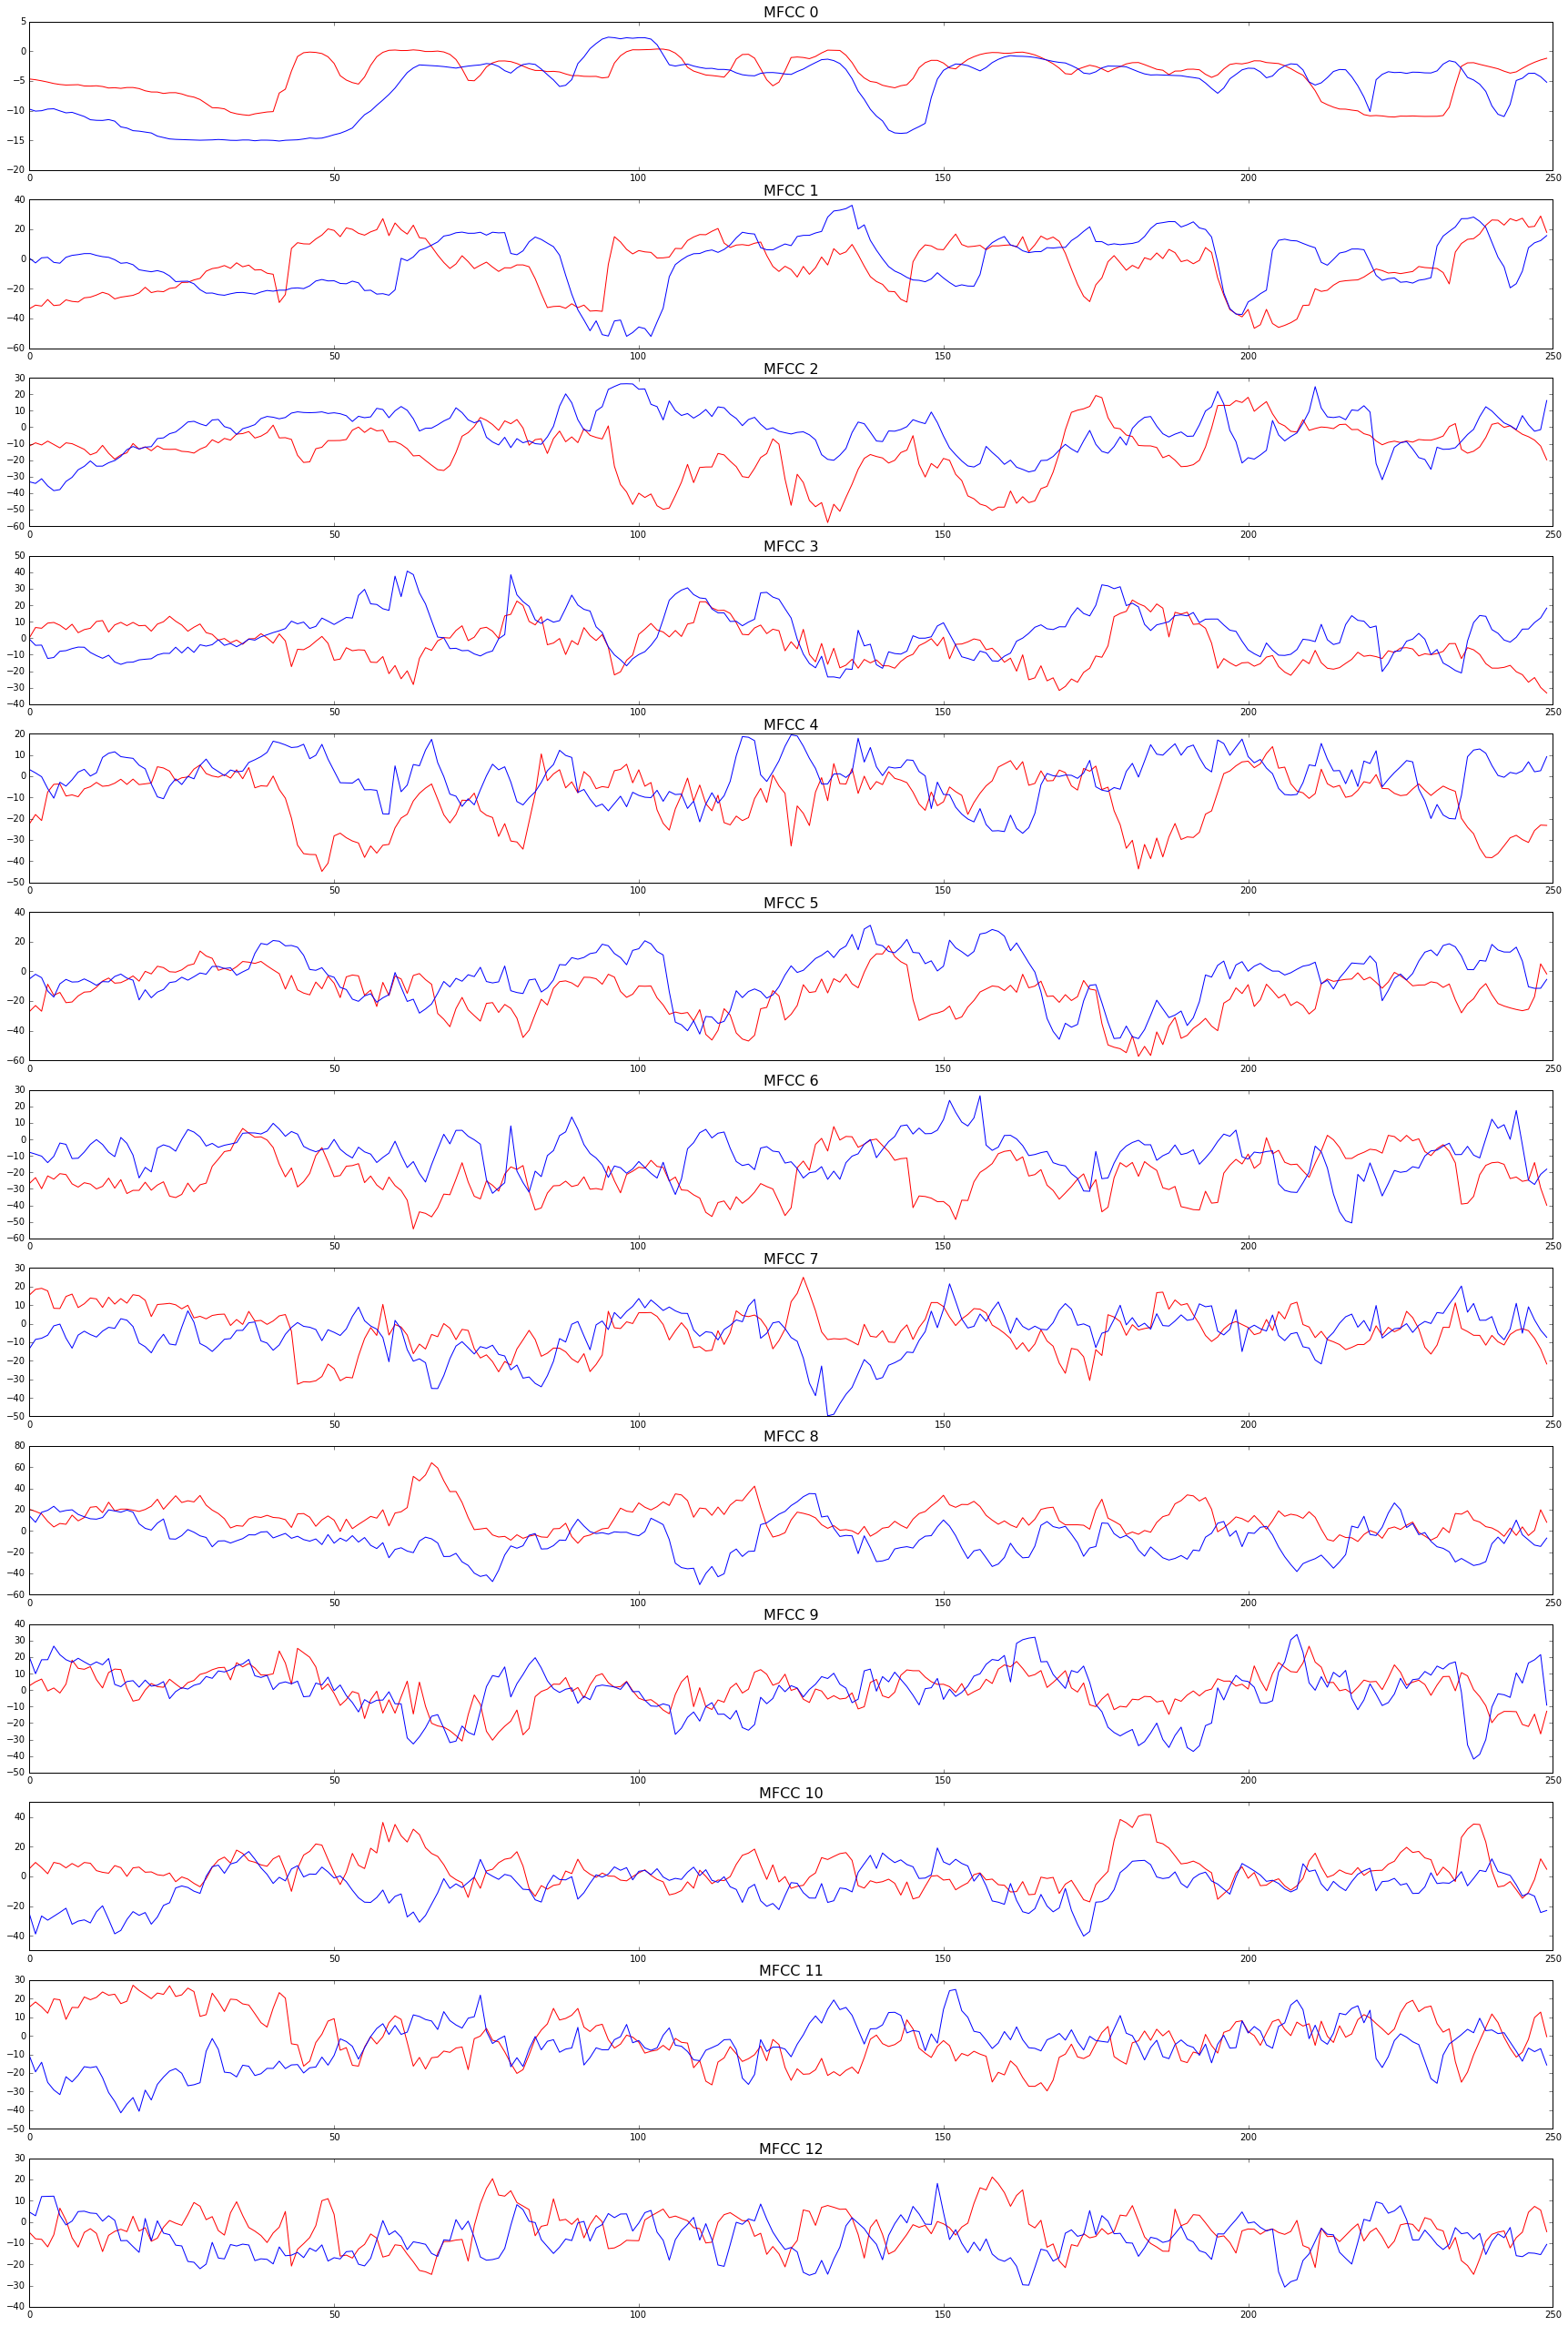

In [7]:
female_MFCC = data[data.gender == 'F'].sample().iloc[0].MFCC
male_MFCC = data[data.gender == 'M'].sample().iloc[0].MFCC

# Plot a temporal graph of the 13 MFCC features over time, for female (red) and male (blue) speakers
fig = plt.figure(1)

for i in range(female_MFCC.shape[1]):
    ax = plt.subplot(female_MFCC.shape[1], 1, i+1)
    ax.set_title("MFCC " + str(i), fontsize=16)
    fline = plt.plot(female_MFCC[:250,i], 'r')
    mline = plt.plot(male_MFCC[:250,i], 'b')
    
fig = plt.gcf()
fig.set_size_inches(30, 45)

We observe that the first MFCC features seems particularyl interesting to differentiate the male and female speaker more than the last ones.

# Features processing



In [8]:
temp = data.copy()

In [9]:
data["Mean"] = data.MFCC.map(lambda x: np.mean(x, axis=0))
data["Std"] = data.MFCC.map(lambda x: np.std(x, axis=0))
data.sample(5)

,MFCC,gender,speaker,Mean,Std
140,"[[-9.560341554, -13.9973270129, -21.3192154039...",M,6241,"[-4.3912091113, -10.5669090665, -11.2819229333...","[3.25339081082, 14.2042431607, 12.8598216774, ..."
279,"[[-10.5675909783, -1.9895029872, -27.963761176...",M,2428,"[-6.23270158983, 1.23960369275, -10.7523629839...","[4.13797905934, 18.5354815063, 14.1486805351, ..."
956,"[[-6.2989147482, -18.4385404934, -5.5519629395...",F,3576,"[-4.71515907069, -3.53446207303, 2.7946828914,...","[2.3710755323, 16.9553534071, 12.9113232405, 1..."
760,"[[-13.1042134901, -15.3025739401, -16.33163874...",F,5338,"[-5.49028922608, -8.27483159081, -9.4169528818...","[3.6849658852, 15.9798159828, 16.9593746389, 1..."
851,"[[-11.2808499819, -9.409352273, 4.0206751616, ...",F,5895,"[-5.32182432286, -18.4142202705, -9.2204390288...","[4.15872076031, 13.9263266085, 16.9453324218, ..."


## Normalization

In order to build efficient model, it is necessary to process the features. Our 13 MFCC features represents frequency band power, from the lowest-pitch to the highest pitch. 

We expect male speech to have more power than female speech in the low-pitch. In order to build an accurate model it is a good idea to standardize the bands of each audiofile.

In [10]:
data["Mean"] = data["Mean"].map(lambda x: x - np.mean(x))
data["Mean"] = data["Mean"].map(lambda x: x / np.std(x))
data["Std"] = data["Std"].map(lambda x: x - np.mean(x))
data["Std"] = data["Std"].map(lambda x: x / np.std(x))
data.sample(5)

,MFCC,gender,speaker,Mean,Std
1183,"[[-6.6012122067, -19.6974777521, -21.943700681...",F,3853,"[0.72730798242, 0.591474803432, -0.9321791008,...","[-2.90726585799, 1.02404107382, 0.082857568884..."
536,"[[-10.5289095064, -2.9904606048, -1.4482047872...",F,3081,"[-0.492383164752, -1.29682663915, 2.4235016697...","[-2.22643921717, 1.13320943583, 0.684662465734..."
758,"[[-7.7287070219, -19.360813582, -32.5623733996...",F,5338,"[0.0932596978574, 0.331859702426, -1.137935177...","[-2.70847855864, 0.674904197316, 0.56219213867..."
1259,"[[-12.7219865995, -7.2916980748, 16.8198312449...",M,777,"[-0.56087732237, -0.469606691007, 0.4780465872...","[-3.054595851, 1.08095977694, 0.125414188638, ..."
691,"[[-12.2615260503, -10.9375045546, 7.211820047,...",M,2086,"[-0.407556443008, 0.39438623192, -0.3320355252...","[-3.09917125583, 0.250096926554, 0.14805415092..."


## Creating training and test sets

### Stats

In [11]:
print("There are {} files audio in total, {} of female speakers and {} of male speakers".format(
        len(data), 
        len(data[data.gender == 'F']),
        len(data[data.gender == 'M'])))

There are 1329 files audio in total, 658 of female speakers and 671 of male speakers


### Splitting

In order to have a relevant train and test set, they must of course be disjoint but we also must ensure that no speaker is present in both the train and the test. Because we expect two different audio files from the same speaker to have correlation in their features, our test set would then not help us to detect overfitting in our models.  

We therefore split the speakers in the test and training set. Since we have 40 speakers (20 female and 20 male), we keep 8 male and 8 female speakers in the test set. This represents 40% of the speakers which is pretty standard for such classification tasks with only 40 different speakers.

In [27]:
female_ids = list(set(data[data.gender == 'F'].speaker))
male_ids = list(set(data[data.gender == 'M'].speaker))

# Select randomly 5 male and 5 female speakers and assign them to the test set
test_ids = list(np.random.choice(female_ids, 8)) + list(np.random.choice(male_ids, 8))
# Assign all other speakers to the train set
train_ids = list(set(data.speaker) - set(test_ids))

# Create train and test audio sets, composed of tuples (audio, gender)
train_data = data[data.speaker.isin(train_ids)].copy()
test_data = data[data.speaker.isin(test_ids)].copy()

We just verify that the audio test set represent a correct ratio (expected around 40% since we selected 40% of the speakers) of the overall data, but it could be more or less because speakers don't have all the same number of audio file.

In [28]:
len(test_data) / len(all_speaker_audio)

0.3852520692249812

# Classification

## Naive classifier

For the naive classifier, I use a Gaussian Naive Bayes model from the sklearn library.

For the naive classifier, for each audio file I use only the mean and standard deviation of the features instead of all the values.

In [29]:
naive_train_features = np.concatenate([np.array(list(train_data.Mean)), np.array(list(train_data.Std))], axis = 1)

In [30]:
naive_test_features = np.concatenate([np.array(list(test_data.Mean)), np.array(list(test_data.Std))], axis = 1)

In [31]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(naive_train_features, np.array(train_data.gender))
y_pred_train = gnb.predict(naive_train_features)
len(train_data[train_data.gender == y_pred_train]) / len(train_data)

0.9253365973072215

In [32]:
test_data["NaivePreds"] = gnb.predict(naive_test_features)

In [33]:
len(test_data[test_data.gender == test_data.NaivePreds]) / len(test_data)

0.833984375

## Random Forest

Let's now use a more sophisticated classifier with a Random Forest. For this classifier, the same features are used (eans and standard deviation of MFCC).



In [34]:
forest_train_features = naive_train_features
forest_test_features = naive_test_features

In [56]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,max_depth=12, max_features=0.25)
clf.fit(forest_train_features, np.array(train_data.gender))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=0.25, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [57]:
y_pred_train = clf.predict(forest_train_features)
len(train_data[train_data.gender == y_pred_train]) / len(train_data)

1.0

In [58]:
test_data["RFPreds"] = clf.predict(forest_test_features)
len(test_data[test_data.gender == test_data.RFPreds]) / len(test_data)

0.810546875

## Neural Network

Let's now use a neural network to build a classifier. The model use is a Multi-layer Perceptron (MLP)

In [59]:
mlp_train_features = naive_train_features
mlp_test_features = naive_test_features

In [60]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(50, 20), random_state=1)
clf.fit(mlp_train_features, np.array(train_data.gender))  

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [61]:
y_pred_train = clf.predict(forest_train_features)
len(train_data[train_data.gender == y_pred_train]) / len(train_data)

1.0

In [62]:
test_data["MLPPreds"] = clf.predict(mlp_test_features)
len(test_data[test_data.gender == test_data.MLPPreds]) / len(test_data)

0.830078125

## Deep Learning Model

In [63]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Using TensorFlow backend.


In [48]:
naive_train_features.shape[1]

26

In [49]:
cnn_train_features = train_data.MFCC
cnn_test_features = test_data.MFCC

In [50]:
cnn_train_features.shape

(967,)

In [51]:
def string2int(cat):
    if cat == 'F':
        return 1
    else:
        return 0

In [52]:
cnn_train_features.shape

(967,)

In [53]:
from keras.utils.np_utils import to_categorical
y_binary = to_categorical(np.array(list(train_data.gender.map(lambda x: string2int(x)))))

In [54]:
np.array([y_binary[0]]).shape

(1, 2)

In [55]:
'''# This returns a tensor
inputs = Input(shape=(cnn_train_features[0].shape[1],))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

for i in range(len(cnn_train_features)):
    model.fit(cnn_train_features[i], y_binary[i])
    
    
#model.fit(cnn_train_features, y_binary)  # starts training
'''

"# This returns a tensor\ninputs = Input(shape=(cnn_train_features[0].shape[1],))\n\n# a layer instance is callable on a tensor, and returns a tensor\nx = Dense(64, activation='relu')(inputs)\nx = Dense(64, activation='relu')(x)\npredictions = Dense(2, activation='softmax')(x)\n\n# This creates a model that includes\n# the Input layer and three Dense layers\nmodel = Model(inputs=inputs, outputs=predictions)\nmodel.compile(optimizer='rmsprop',\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\nfor i in range(len(cnn_train_features)):\n    model.fit(cnn_train_features[i], y_binary[i])\n    \n    \n#model.fit(cnn_train_features, y_binary)  # starts training\n"

In [61]:
# create model
model = Sequential()
model.add(LSTM(100, return_sequences=True, stateful=True, input_shape=(None, 13),
         batch_input_shape=(1, None, 13)))
model.add(LSTM(100))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#model.fit(cnn_train_features, [y_binary[i]], batch_size = 1)

nb = 0
for i in range(len(cnn_train_features)):
    if nb % 10 == 0: 
        print("trained " + str(nb) + "/" + str(len(cnn_train_features)))
    model.fit(np.array([cnn_train_features.iloc[i]]), np.array([y_binary[i]]), batch_size = 1, verbose = 0 )
    nb += 1

trained 0/967
trained 10/967
trained 20/967
trained 30/967
trained 40/967
trained 50/967
trained 60/967
trained 70/967
trained 80/967
trained 90/967
trained 100/967
trained 110/967
trained 120/967
trained 130/967
trained 140/967
trained 150/967
trained 160/967
trained 170/967
trained 180/967
trained 190/967
trained 200/967
trained 210/967
trained 220/967
trained 230/967
trained 240/967
trained 250/967
trained 260/967
trained 270/967
trained 280/967
trained 290/967
trained 300/967
trained 310/967
trained 320/967
trained 330/967
trained 340/967
trained 350/967
trained 360/967
trained 370/967
trained 380/967
trained 390/967
trained 400/967
trained 410/967
trained 420/967
trained 430/967
trained 440/967
trained 450/967
trained 460/967
trained 470/967
trained 480/967
trained 490/967
trained 500/967
trained 510/967
trained 520/967
trained 530/967
trained 540/967
trained 550/967
trained 560/967
trained 570/967
trained 580/967
trained 590/967
trained 600/967
trained 610/967
trained 620/967
tra

In [ ]:
# create model
model = Sequential()
model.add(LSTM(100, return_sequences=True, stateful=True, input_shape=(None, 13),
         batch_input_shape=(1, None, 13)))
model.add(LSTM(100))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

for i in range(len(cnn_train_features)):
    model.fit(np.array([cnn_train_features.iloc[i]]), np.array([y_binary[i]]), batch_size = 1)
    

In [156]:
def prob2cat(probs):
    if probs[0] > 0.5:
        return 'M'
    else:
        return 'F'

In [160]:
test_data["CNNPreds"] = list(map(lambda x: prob2cat(x), model.predict(cnn_test_features)))

In [1]:
len(test_data[test_data.CNNPreds == test_data.gender]) / len(test_data)

NameError: name 'test_data' is not defined

In [62]:
model.save('cnn_model.h5')

In [66]:
model = load_model('cnn_model.h5')

In [77]:
cnn_preds = []
for i in range(len(cnn_test_features)):
    if model.predict(np.array([cnn_test_features.iloc[i]]))[0][0] > 0.5:
        cnn_preds.append('M')
    else:
        cnn_preds.append('F')

In [78]:
test_data["CNNPreds"] = cnn_preds

In [79]:
sum(test_data.CNNPreds == test_data.gender) / len(test_data)

0.48342541436464087

### Splitting features in batch of same size

In [85]:
print("Smaller audio file contains {} frames".format(min(data.MFCC.map(lambda x: len(x)))))

Smaller audio file contains 143 frames


In [123]:
X_train = []
y_train = []
split_size = 20

for mfcc, gender in zip(train_data.MFCC, train_data.gender):
    for i in range(int(len(mfcc)/split_size)): 
        X_train.append(mfcc[i*split_size:(i+1)*split_size])
        y_train.append(string2int(gender))
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [128]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)

In [188]:
# create model
model = Sequential()
model.add(LSTM(100, return_sequences=True, stateful=True, input_shape=X_train[0].shape,
               batch_input_shape=(1, 20, 13)))
model.add(LSTM(100))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size = 1)    

Epoch 1/10
37375/37375 [==============================] - 674s 18ms/step - loss: 0.3584 - acc: 0.8694
Epoch 2/10
37375/37375 [==============================] - 774s 21ms/step - loss: 0.3240 - acc: 0.8979
Epoch 3/10
37375/37375 [==============================] - 794s 21ms/step - loss: 0.3176 - acc: 0.9033
Epoch 4/10
37375/37375 [==============================] - 815s 22ms/step - loss: 0.3091 - acc: 0.9045
Epoch 5/10
37375/37375 [==============================] - 790s 21ms/step - loss: 0.3128 - acc: 0.9057
Epoch 6/10
37375/37375 [==============================] - 790s 21ms/step - loss: 0.3078 - acc: 0.9059
Epoch 7/10
37375/37375 [==============================] - 789s 21ms/step - loss: 0.3206 - acc: 0.9037
Epoch 8/10
37375/37375 [==============================] - 785s 21ms/step - loss: 0.3165 - acc: 0.9091
Epoch 9/10
37375/37375 [==============================] - 796s 21ms/step - loss: 0.3348 - acc: 0.9051
Epoch 10/10
37375/37375 [==============================] - 805s 22ms/step - loss: 

In [189]:
model.save('lstm_model_batch1.h5')

In [190]:
#model.save('lstm_model.h5')

In [191]:
X_test = []
y_test = []

for mfcc, gender in zip(test_data.MFCC, test_data.gender):
    for i in range(int(len(mfcc)/split_size)): 
        X_test.append(mfcc[i*split_size:(i+1)*split_size])
        y_test.append(string2int(gender))
        
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = to_categorical(y_test)

In [192]:
preds = model.predict(X_test,  batch_size = 1)

In [193]:
preds[0][0]

0.99971718

In [194]:
y_test[0]

array([ 1.,  0.])

In [196]:
test_accuracy = len(list(filter(lambda x: abs(x[0]) < 0.5, y_test - preds))) / 12311
test_accuracy

0.7908374624319714

In [199]:
def predictGender(model, mfcc):
    features = []
    nb_batch = int((len(mfcc)/split_size))
    for i in range(nb_batch): 
        features.append(mfcc[i*split_size:(i+1)*split_size])
    
    features = np.array(features)
    preds = model.predict(features, batch_size = 1)
    pred = np.sum(preds, axis = 0)
    if(pred[0] > pred[1]):
        return 'M'
    else:
        return 'F'

In [200]:
LSTMPreds = []
for mfcc in test_data.MFCC:
    LSTMPreds.append(predictGender(model, mfcc))

In [201]:
test_data["LSTMPreds"] = LSTMPreds

In [202]:
len(test_data.LSTMPreds == test_data.gender) / len(test_data)

1.0